### Homework 2 - Data from the Web

#### 1. Extract data

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame.

In [1]:
%matplotlib inline  
import requests
import pandas as pd
import json
import difflib
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

SOURCE="www.topuniversities.com"
LIST=SOURCE + "/university-rankings/world-university-rankings/2018"
DATA_SOURCE="www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

LIMIT=200

In [2]:
# Some helpers used to clean data from scrapping
def clean_numerical_data(data):
    return int(data.replace('\n', '').replace(',', ''))

def clean_percentage_data(data):
    return int(data.replace('%', '')) / 100

def safe_parse(page, selector):
    try:
        return clean_numerical_data(page.select(selector)[0].text)
    except:
        return None

In [3]:
# Here we use CSS Selector to easily extract data from web pages
def extract_faculty_members(page):
    total = safe_parse(page, "div.total.faculty div.number")
    international = safe_parse(page, "div.inter.faculty div.number")
    return total, international
    
def extract_student_members(page):
    total = safe_parse(page, "div.total.student div.number")
    international = safe_parse(page, "div.total.inter  div.number")
    return total, international

def extract_data(university):
    url = SOURCE + university['url']
    data = requests.get("http://" + url).text
    page = BeautifulSoup(data, "html5lib")
    
    total_faculty, inter_faculty = extract_faculty_members(page)
    total_student, inter_student = extract_student_members(page)

    university['total_faculty'] = total_faculty
    university['inter_faculty'] = inter_faculty
    university['total_student'] = total_student
    university['inter_student'] = inter_student
    
    return university

In [4]:
# Extract JSON from url, retrieve only data
def extract_list(url):
    data = requests.get("http://" + url).text
    return json.loads(data)['data']
    
university_list = extract_list(DATA_SOURCE)[:LIMIT]

In [5]:
university_list = [extract_data(university) for university in university_list]

In [6]:
KEEP_TOP = ['title', 'rank_display', 'cc', 'region', 'total_faculty', 'total_student', 'inter_faculty', 'inter_student']
university_list = [ {key: university[key] for key in KEEP_TOP} for university in university_list]

In [7]:
df_top = pd.DataFrame(university_list)
df_top.index = df_top['title']
df_top

,cc,inter_faculty,inter_student,rank_display,region,title,total_faculty,total_student
title,,,,,,,,
Massachusetts Institute of Technology (MIT),US,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0
Stanford University,US,2042.0,3611.0,2,North America,Stanford University,4285.0,15878.0
Harvard University,US,1311.0,5266.0,3,North America,Harvard University,4350.0,22429.0
California Institute of Technology (Caltech),US,350.0,647.0,4,North America,California Institute of Technology (Caltech),953.0,2255.0
University of Cambridge,GB,2278.0,6699.0,5,Europe,University of Cambridge,5490.0,18770.0
University of Oxford,GB,2964.0,7353.0,6,Europe,University of Oxford,6750.0,19720.0
UCL (University College London),GB,2554.0,14854.0,7,Europe,UCL (University College London),6345.0,31080.0
Imperial College London,GB,2071.0,8746.0,8,Europe,Imperial College London,3930.0,16090.0
University of Chicago,US,635.0,3379.0,9,North America,University of Chicago,2449.0,13557.0


#### 1.b Which are the best universities in term of:

##### (a) ratio between faculty members and students

There are two possible ratio that can be used to answer this question, we can either use the **total** statistics or the **international** ones, we though it is more meaningful to use the **total** to answers this question 

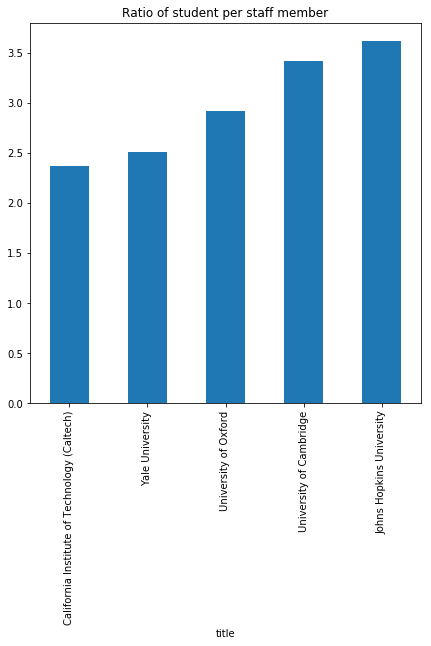

In [8]:
def staff_student_ratio(df):
    df['ratio_faculty_student'] = df['total_student'] /  df['total_faculty']
    return df.sort_values('ratio_faculty_student')

staff_student_ratio(df_top)['ratio_faculty_student'].head().plot(kind='bar', figsize=(7,7), title="Ratio of student per staff member")

We see that universities with the best ratio between faculty staff and students are located in the US or in GB but that this metric is not closely linked with the rank of the university

##### (b) ratio of international students?

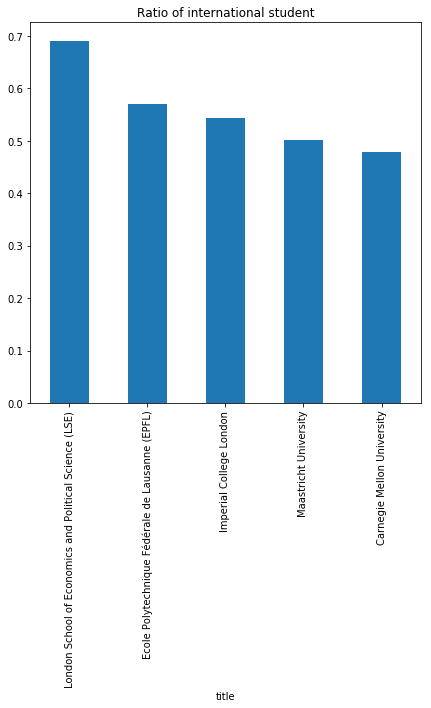

In [9]:
def inter_student_ratio(df):
    df['ratio_inter_student'] = df['inter_student'] / df['total_student']
    return df.sort_values('ratio_inter_student', ascending=False)

inter_student_ratio(df_top)['ratio_inter_student'].head().plot(kind='bar', figsize = (7,7), title="Ratio of international student")

Here, we can see that the most international university are mostly located in Europe.

We now need to compute the same ratio, but this time, we'll add some aggregation

##### Country aggregation

The first aggregation we want to perform is aggretion by country, we simply `groupby` the dataframe using the **cc** column and then call the same methods previously created (`staff_student_ratio` and `inter_student_ratio`)

In [10]:
df_country = df_top.groupby('cc')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

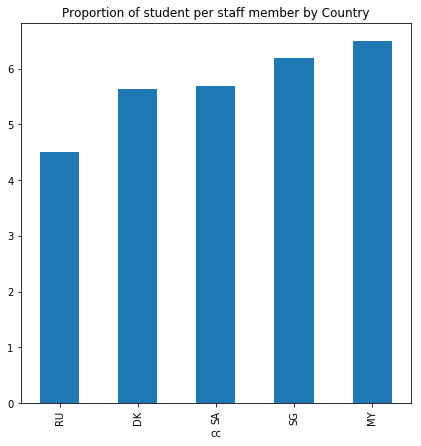

In [11]:
staff_student_ratio(df_country)['ratio_faculty_student'].head().plot(kind='bar', figsize=(7, 7), title="Proportion of student per staff member by Country")

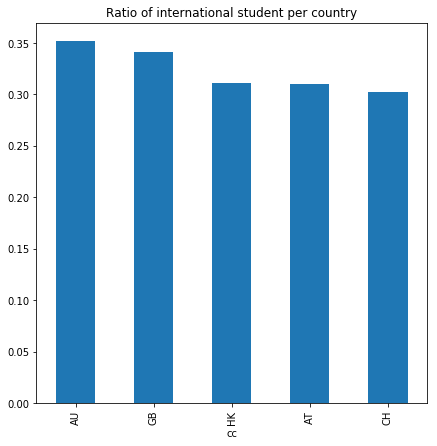

In [12]:
inter_student_ratio(df_country)['ratio_inter_student'].head().plot(kind='bar', figsize=(7, 7), title="Ratio of international student per country")

##### Region aggregation

The second aggregation we want to perform is an aggregation by region, same as before, we simply `groupby` and call the methods on the newly created dataframe.

In [13]:
df_region = df_top.groupby('region')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

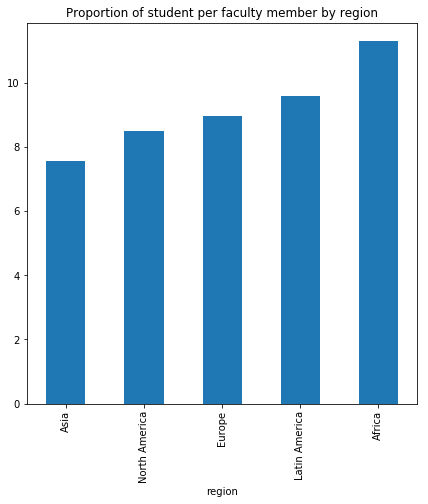

In [14]:
staff_student_ratio(df_region)['ratio_faculty_student'].head().plot(kind='bar',  figsize=(7, 7), title="Proportion of student per faculty member by region")

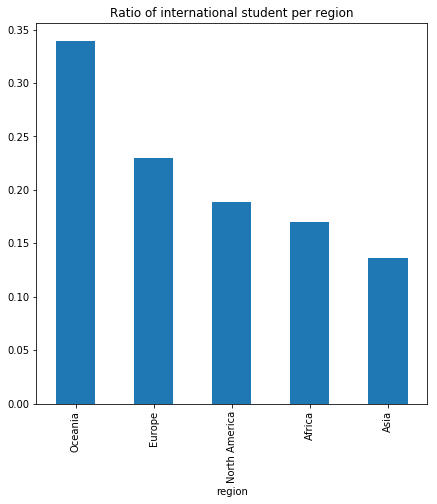

In [15]:
inter_student_ratio(df_region)['ratio_inter_student'].head().plot(kind='bar', figsize=(7,7), title="Ratio of international student per region")

### Data from timeshighereducation

Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [16]:
SOURCE="www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
university_list_2 = extract_list(SOURCE)[:LIMIT]

In [17]:
df_times = pd.DataFrame(university_list_2)

df_times['total_student'] = df_times['stats_number_students'].apply(clean_numerical_data)
df_times['ratio_faculty_student'] = df_times['stats_student_staff_ratio'].apply(float)
df_times['ratio_inter_student'] = df_times['stats_pc_intl_students'].apply(clean_percentage_data)
df_times['title'] = df_times['name']
df_times['rank_display'] = df_times['rank']
df_times['cc'] = df_times['location']

KEEP_TIMES = ['title', 'rank_display', 'cc', 'total_student', 'ratio_faculty_student', 'ratio_inter_student']
df_times = df_times[KEEP_TIMES]
df_times.index = df_times['title']

Here we graph the same data we plotted for the topuniversities ranking, except that we don't have the region for each university, one way we could fix that is to find the region for a given country code.

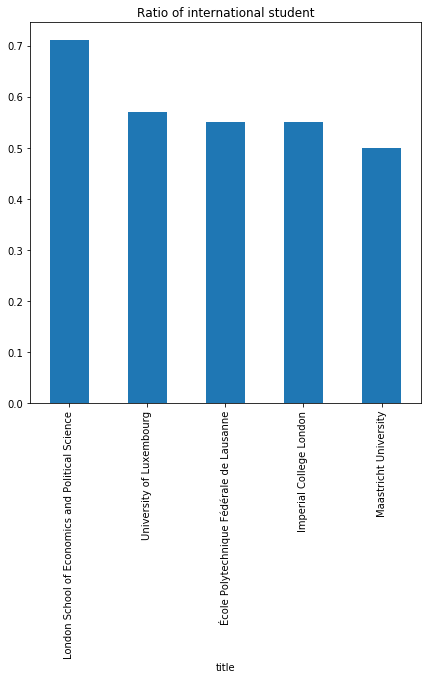

In [18]:
df_times.sort_values('ratio_inter_student', ascending=False)['ratio_inter_student'].head().plot(kind='bar', figsize = (7,7), title="Ratio of international student")

For this metric, we get almost the same data as from topuniversities, except for Luxembourg, because it has a rank greater than 200 according to TopUniversities

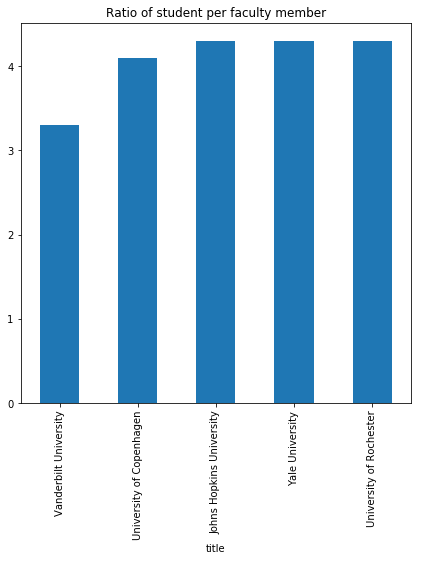

In [19]:
df_times.sort_values('ratio_faculty_student')['ratio_faculty_student'].head().plot(kind='bar', figsize = (7,7), title="Ratio of student per faculty member")

Here we have some different result, some university have a much better ratio according to timeshigherrank than with topuniversities.
We now are going to compare those metric aggregated by country:

In [20]:
df_times_country = df_times.groupby('cc')['ratio_faculty_student', 'ratio_inter_student'].median()

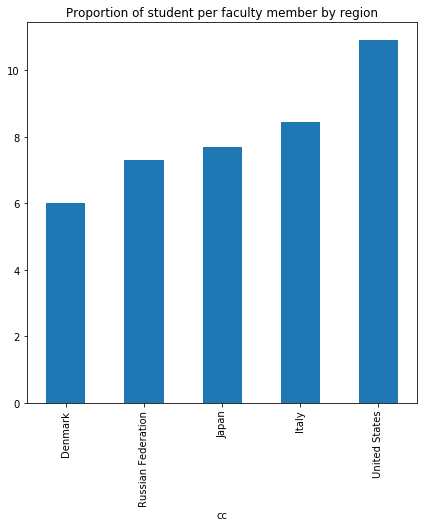

In [21]:
df_times_country.sort_values('ratio_faculty_student')['ratio_faculty_student'].head().plot(kind='bar',  figsize=(7, 7), title="Proportion of student per faculty member by region")

In [22]:
import re
# Here we remove some very commons words that reduce the "uniqueness" of the name
def remove_common_word(word):
    return re.sub(r'\(.*\)', '', word).replace('University', '0').replace('Technology', '1').replace('Institute', '2').replace(' of ', ' ').replace('Scuola', '').replace(' the ', ' ').rstrip().lstrip().lower()

# There are many ways to perform the matching, but sometimes, it's simply not possible
# This is the case for instance for the University of Paris-Sud, which is not in the < 200 ranking according to topuniversities
# Or luxembourg (which is not even in the list)
def match_university_name(name, currents, others):
    tmp = [x for x in others if  name == x]
    if len(tmp): return tmp[0]
    
    matches = difflib.get_close_matches(name, others)
    result = 'undefined'
    if len(matches) == 0:
        if len(name.split(' ')) == 1: # It's often University with only the city name remaining
            tmp = [x for x in others if  name in x]
            if len(tmp): result = tmp[0]
        else:
            pass
    else:
        tmp = matches[0]
        match_reverse = difflib.get_close_matches(tmp, currents)
        if len(match_reverse):
            if match_reverse[0] == name:
                result = tmp

    return result

df_top['cleared_title'] =  df_top['title'].apply(lambda x: remove_common_word(x))
df_times['cleared_title'] = df_times['title'].apply(lambda x: remove_common_word(x))

df_times['title_mapped'] = df_times['cleared_title'].map(lambda x: match_university_name(x, df_times['cleared_title'],df_top['cleared_title']))
df_top['title_mapped'] =  df_top['cleared_title'] 

df_times.index = df_times['title_mapped']
df_top.index = df_top['title_mapped']

In [23]:
df_join = df_times.join(df_top, on='title_mapped', how='inner', lsuffix='_times', rsuffix='_top')
df_join[['cleared_title_times', 'cleared_title_top', 'title_times', 'title_top', 'rank_display_times', 'rank_display_top']]

,cleared_title_times,cleared_title_top,title_times,title_top,rank_display_times,rank_display_top
title_mapped,,,,,,
0 oxford,0 oxford,0 oxford,University of Oxford,University of Oxford,1,6
0 cambridge,0 cambridge,0 cambridge,University of Cambridge,University of Cambridge,2,5
california 2 1,california 2 1,california 2 1,California Institute of Technology,California Institute of Technology (Caltech),=3,4
stanford 0,stanford 0,stanford 0,Stanford University,Stanford University,=3,2
massachusetts 2 1,massachusetts 2 1,massachusetts 2 1,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT),5,1
harvard 0,harvard 0,harvard 0,Harvard University,Harvard University,6,3
princeton 0,princeton 0,princeton 0,Princeton University,Princeton University,7,13
imperial college london,imperial college london,imperial college london,Imperial College London,Imperial College London,8,8
0 chicago,0 chicago,0 chicago,University of Chicago,University of Chicago,9,9


: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members